In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import lal
from pycbc import waveform
from tqdm import tqdm

# PLOTTING OPTIONS
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

In [2]:
c = 3e8
G = 6.67e-11
pc2m = 3.086e16
yr2s = 3.154e7
solarmass = 2e30
from astropy.cosmology import Planck18  # Planck 2018
from scipy.integrate import quad
from scipy import optimize

In [3]:
def dE_df(mass1,mass2,freq=25):
    '''
    Return the dE/df given a mass and distance of a BBH merger
    '''
    #distance_mpc = Planck18.luminosity_distance(z).value
    distance_mpc = 1 # distance cancels out with the denominator in h(f), so it doesn't quite matter here
    delta_f = 1/4
    sptilde, _ = waveform.get_fd_waveform(approximant="IMRPhenomD",
                                              mass1=mass1, 
                                              mass2=mass2, 
                                              delta_f=delta_f,
                                              f_lower=20,
                                              distance=distance_mpc)
    ind = int(freq/ delta_f)
    try:
        sptildedata = sptilde.data[ind]
    except IndexError:
        return 0
    return 8/5*np.pi**2*c**3/G*freq**2*(distance_mpc*1e6*pc2m)**2* \
                (np.abs(sptildedata))**2

# Comparison between a (37,1) solar mass binary merger and a (5,5) binary merger dE/df

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


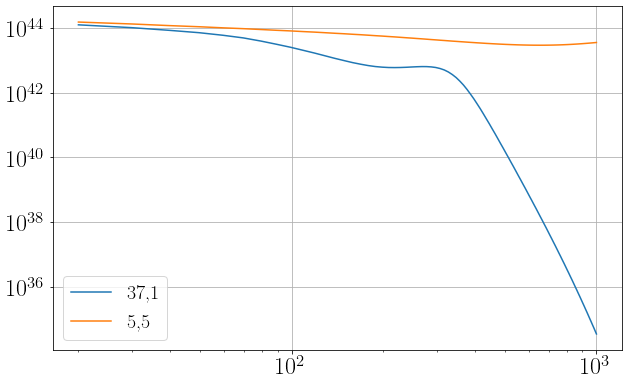

In [4]:
ef1 = []
ef2 = []
freq = np.linspace(20,1000,100)
for f in freq:
    ef1.append( dE_df(37,1,f))
    ef2.append( dE_df(5,5,f))
ef1 = np.array(ef1)
ef2 = np.array(ef2)
plt.plot(freq,ef1,label='37,1')
plt.plot(freq,ef2,label='5,5')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [5]:
t0 = Planck18.age(0).value # age of the Universe
def rate_deltamass(m,f,z):
    '''
    m is mass
    f is fraction of PBH in dark matter
    z is the redshift
    '''
    sigma_eq = 0.005
    t = Planck18.age(z).value
    return 3e6 * (t/t0)**(-34/37) * f**2*(0.7*f**2+sigma_eq**2)**(-21./74)*m**(-32/37)

def rate_twomass(m1,m2,p_m1,z):
    # fix the primary mass's f_pbh to be 3e-3
    f_pbh_m1 = 3e-3
    # the fraction of p1 is a free variable
    p1 = p_m1
    p2 = 1-p1
    # the total fraction of PBH including m1 and m2
    f = f_pbh_m1/p_m1
    sigma_eq = 0.005
    t = Planck18.age(z).value
    return 3e6 * (t/t0)**(-34/37) * f**2 * (0.7*f**2+sigma_eq**2)**(-21./74) \
            *min(p1/m1,p2/m2)*(p1/m1+p2/m2)*(m1*m2)**(3./37)*(m1+m2)**(36./37)

def E_of_z(z):
    return np.sqrt(Planck18.Om0*(1+z)**3+(1-Planck18.Om0))

In [6]:
class sgwb(object):
    def __init__(self,mass1,mass2,search_type='comparable'):
        '''
        search_type = comparable or highmassratio or test
        '''
        self.mass1 = mass1
        self.mass2 = mass2
        self.search_type = search_type
        self.unit_const = (1e9*pc2m)**3*yr2s
        self.rho_c = 3*lal.H0_SI**2*c**2/8/np.pi/G
        if self.search_type == 'comparable':
            if self.mass1 != self.mass2:
                sys.exit('This is comparable mass model! m1 must equal to m2!')
        self.integrand = {'comparable': self.integrand_comparablemass,
                 'test': self.integrand_test,
                 'astro': self.integrand_astro,
                 'highmassratio':self.integrand_highmassratio}
    def integrand_highmassratio(self, z, det_freq, fraction):
        '''
        det_freq: the frequency in detector frame
        fraction: f_secondary
        '''
        freq_source = det_freq * (1+z)
        p_m1 = 0.003 / (0.003 + fraction)
        return rate_twomass(self.mass1,self.mass2,p_m1, z) \
            /self.unit_const/(1+z)/E_of_z(z)*dE_df(self.mass1,self.mass2,freq_source)
  
    def integrand_comparablemass(self, z, det_freq, fraction):
        '''
        det_freq: the frequency in detector frame
        '''
        freq_source = det_freq * (1+z)
        return rate_deltamass(self.mass1,fraction,z)/self.unit_const/(1+z)/E_of_z(z)*dE_df(self.mass1,self.mass2,freq_source)
    
    def integrand_test(self,z,det_freq,fraction):
        #set the mass to be the same: all are 0.1 solar mass
        return deltamass_rate(0.1,fraction,0)/self.factor_rate/(1+z)/E_of_z(z)*dE_df(self.mass1,self.mass2,det_freq)
    
    def integrand_astro(self, z, det_freq, fraction):
        '''
        det_freq: the frequency in detector frame
        '''
        freq_source = det_freq * (1+z)
        rbbh = 19
        return sfr(z)/sfr(0)*rbbh/self.unit_const/(1+z)/E_of_z(z)*dE_df(self.mass1,self.mass2,freq_source)
 
    def omega_gw_freq(self,fraction,freq_val=25):
        z_low, z_high = 0, 20
        I = quad(self.integrand[self.search_type], z_low, z_high, args=(freq_val,fraction))
        return freq_val / self.rho_c / lal.H0_SI * I[0]
    
    def omega_gw_array(self,fraction,freq_array = np.logspace(1,5,100)):
        omega = []
        z_low, z_high = 0, 20

        for freq_val in tqdm(freq_array):
            I = quad(self.integrand[self.search_type], z_low, z_high, args=(freq_val,fraction))
            omega.append( freq_val / self.rho_c / lal.H0_SI * I[0])
        return np.asarray(omega)

# Comparable SGWB constraint

In [8]:
# here I only need to compute the 25Hz SGWB value, to compare with the LVK results
# Given by https://journals.aps.org/prd/pdf/10.1103/PhysRevD.104.022004
#LVK_upper = 3.4e-9
LVK_upper = 1.2e-8

mass = np.arange(0.1,1.1,0.1)
constraint = []

In [10]:
for m in tqdm(mass):
    sgwb_com = sgwb(m,m,'comparable')
    def CacheFunction(f):
        return sgwb_com.omega_gw_freq(f) - LVK_upper
    sol = optimize.root_scalar(CacheFunction, bracket=[5e-3, 1], method='brentq')
    constraint.append(sol.root)   

100%|██████████| 10/10 [00:50<00:00,  5.02s/it]


In [11]:
np.savetxt('sgwb_com_mass_uniform.txt',np.transpose([mass,constraint]))

In [12]:
m,c = np.loadtxt('sgwb_com_mass.txt',unpack=True)

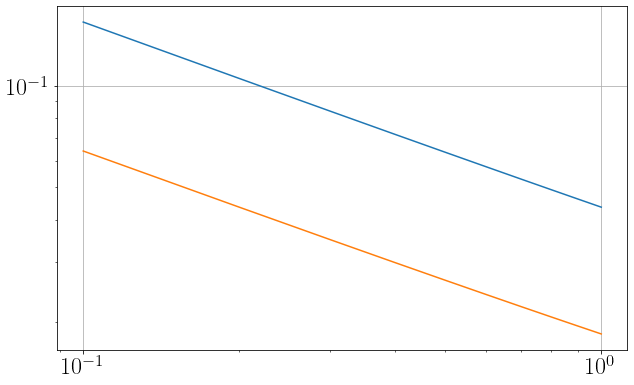

In [13]:
plt.loglog(mass,constraint)
plt.loglog(m,c)

In [ ]:
#np.savetxt('sgwb_com_mass.txt',np.transpose([mass,constraint]))

# High mass ratio

In [ ]:
hmr_upper = 5.8e-9
mass = np.append( np.arange(0.02,0.1,0.01), np.arange(0.1,1.1,0.1))
constraint = []

for m in tqdm(mass):
    sgwb_hms = sgwb(37,m,'highmassratio')
    def CacheFunction(f):
        return sgwb_hms.omega_gw_freq(f) - hmr_upper
    sol = optimize.root_scalar(CacheFunction, bracket=[1e-3, 1], method='brentq')
    constraint.append(sol.root)   

In [ ]:
plt.loglog(mass,constraint)
plt.xlim(0.02,1)

In [ ]:
freq = np.linspace(10,500,100)
for i in range(len(mass)):
    sgwb_hms = sgwb(37,mass[i],'highmassratio')
    omega_gw_hms = sgwb_hms.omega_gw_array(constraint[i],freq)
    np.savetxt('./hmr/mass_%.2f.txt' % (mass[i]),np.transpose([freq,omega_gw_hms]))

In [ ]:
for i in range(len(mass)):
    f = np.loadtxt('./hmr/mass_%.2f.txt' % mass[i])
    plt.plot(f[:,0],f[:,1],label=r'mass=%.2f, $f_\mathrm{pbh}$=%.3f' % (mass[i],constraint[i]))

plt.ylim(1e-10,)
plt.xlim(20,)
plt.xscale('log')
plt.yscale('log')
plt.scatter(25,hmr_upper,marker='*',color='black',label='LVK 25Hz upper limit')
plt.title('SGWB shape')
x= [25,1000]
y = [hmr_upper,(x[1]/x[0])**(0)*hmr_upper]
plt.loglog(x,y,label='power law (index 0)')
plt.legend(ncol=1,bbox_to_anchor=(1.1, 1.05))

# Recalculate the SGWB upper limit for hmr

In [ ]:
def load_Ysig(filename):
    """
    Read in CC spectra file
    """
    freqs,Y_f,sigma_f = np.loadtxt(filename,unpack=True)
    return Y_f,sigma_f,freqs

def band_with_X_percent_of_sensitivity(Y,sig,freqs,X=99,alpha=0,fref=25):
    """
    Compute f_99
    """
    x=X/100.
    Hf=(freqs/fref)**alpha
    cum_var_m2 = np.cumsum(sig**(-2) * Hf**2)
    cum_sens = np.sqrt(cum_var_m2)
    sens_f = cum_sens / cum_sens[-1]
    ii_x = np.argmin(np.abs(sens_f-x))
    return freqs[ii_x]

def calc_broadband_estimators(Y,sig,freqs,alpha=0,fref=25):
    """
    Compute point estimate and error bar from CC spectra by combining frequency bins
    """
    w = (freqs/fref)**alpha
    Ya = Y / w
    siga = sig / w
    cut = np.logical_not(Y==0)
    sigbb = 1/np.sqrt(np.sum(siga[cut]**(-2)))
    Ybb = np.sum(Ya[cut]/siga[cut]**(2)) * sigbb**2
    return Ybb, sigbb

In [ ]:
filenames=dict(
      HLV='C_O1_O2_O3.dat')
baselines=['HLV']

for baseline in baselines:
    print(baseline)
    Y,sig,freqs=load_Ysig(filenames[baseline])
    Ybb0,sigbb0=calc_broadband_estimators(Y,sig,freqs,alpha=0,fref=25)
    Ybb2_3,sigbb2_3=calc_broadband_estimators(Y,sig,freqs,alpha=2./3,fref=25)
    Ybb3,sigbb3=calc_broadband_estimators(Y,sig,freqs,alpha=-2/3,fref=25)

    print('\talpha=0: Y=%2.2e +/- %2.2e'%(Ybb0,sigbb0))
    print('\talpha=2/3: Y=%2.2e +/- %2.2e'%(Ybb2_3,sigbb2_3))
    print('\talpha=-2/3: Y=%2.2e +/- %2.2e'%(Ybb3,sigbb3))

# Plot the SGWB shape

In [ ]:
freq = np.logspace(1,4,100)
for i,m in enumerate(mass):
    sgwb_com = sgwb(m,m,'comparable')
    omega_gw = sgwb_com.omega_gw_array(constraint[i],freq)
    np.savetxt('./SGWB-shape-data/mass_%f.txt' % (m),np.transpose([freq,omega_gw]))
    plt.loglog(freq,omega_gw,label=r'mass=%f, $f_\mathrm{pbh}$=%.3f' % (m,constraint[i]))
    plt.ylim(1e-10,)
    plt.xlim(20,)

plt.scatter(25,LVK_upper,marker='*',color='black',label='LVK 25Hz upper limit')
plt.title('SGWB shape')
x= [25,1000]
y = [LVK_upper,(x[1]/x[0])**(2/3)*LVK_upper]
plt.loglog(x,y,label='power law (index 2/3)')
plt.legend()

In [ ]:
freq = np.logspace(1,4,100)
for i,m in enumerate(mass):
    f = np.loadtxt('./SGWB-shape-data/mass_%f.txt' % (m))
    plt.loglog(f[:,0],f[:,1],label=r'mass=%.1f, $f_\mathrm{pbh}$=%.3f' % (m,constraint[i]))

plt.xlim(20)
plt.ylim(1e-9,)
plt.scatter(25,LVK_upper,marker='*',color='black',label='LVK 25Hz upper limit')
x= [25,10000]
y = [LVK_upper,(x[1]/x[0])**(2/3)*LVK_upper]
plt.loglog(x,y,label='power law (index 2/3)',ls='--')

plt.legend(ncol=1,bbox_to_anchor=(1.1, 1.05))
plt.xlabel('Frequency [Hz]')
plt.ylabel('$\Omega_\mathrm{GW}$')
plt.savefig('./SGWB-shape-data/sgwbshape.pdf',bbox_inches='tight')

# The second test: Reproduce LVK results

In [ ]:
def sfr(z):    # SFR, Vangioni
    nu = 0.146
    a = 2.80
    b = 2.46
    z_m = 1.72
    return nu * a * np.exp(b*(z-z_m)) / (a - b + b * np.exp(a * (z - z_m)) )

In [ ]:
sfr(0)

In [ ]:
sgwb_astro = sgwb(30,30,'astro')
freq = np.linspace(20,1000,100)
omega_gw_astro = sgwb_astro.omega_gw_array(fraction=1,freq_array=freq)

In [ ]:
# BBH data
bbhData = np.load('../LVKfile/BBH_backgrounds.npy',allow_pickle=True,encoding='latin1')[()]
bbhBackgrounds = bbhData['OmgGW']
bbh_freqs = bbhData['f']
bbh_omg_05 = np.quantile(bbhBackgrounds,0.05,axis=0)
bbh_omg_50 = np.quantile(bbhBackgrounds,0.50,axis=0)
bbh_omg_95 = np.quantile(bbhBackgrounds,0.95,axis=0)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(20,1000)
ax.set_ylim(3e-11,1e-7)
ax.xaxis.grid(True,which='major',ls=':',color='grey')
ax.yaxis.grid(True,which='major',ls=':',color='grey')
ax.set_xlabel(r'$f\,(\mathrm{Hz})$',fontsize=10)
ax.set_ylabel(r'$\Omega_\mathrm{GW}(f)$',fontsize=10)
ax.set_xscale('log')
ax.set_yscale('log')

# Plot individual contributions
ax.fill_between(bbh_freqs,bbh_omg_05,bbh_omg_95,facecolor='#33a02c',alpha=0.8,lw=0.5,zorder=3,edgecolor='black',label='BBH')
ax.plot(freq,omega_gw_astro,label='BBH mass=10 R(0)=19')

# Load PI curve data
freqs_O1O2,PI_O1O2 = np.loadtxt('../LVKfile/PICurve_O2.dat',unpack=True)
freqs_O3,PI_O3 = np.loadtxt('../LVKfile/PICurve_O3.dat',unpack=True)
freqs_design,PI_design = np.loadtxt('../LVKfile/PICurve_HLV_Design.dat',unpack=True)
freqs_aplus,PI_aplus = np.loadtxt('../LVKfile/PICurve_Aplus_Design.dat',unpack=True)

# Plot 2sigma PI curves
ax.plot(freqs_O1O2,2.*PI_O1O2,dashes=(1,1),label='O2',zorder=1,lw=1.2,color='#5e5e5e')
ax.plot(freqs_O3,2.*PI_O3,color='black',label='O3',zorder=1)
ax.plot(freqs_design,2.*PI_design,color='#5e5e5e',dashes=(2,1.5),label='Design HLV',lw=1.2,zorder=1)
ax.plot(freqs_aplus,2.*PI_aplus,color='#5e5e5e',dashes=(3,1,1,1),label='Design A+',lw=1.2,zorder=1)
ax.legend(bbox_to_anchor=(1.1, 1.05))
fig.savefig('./SGWB-shape-data/compareLVK.pdf',bbox_inches='tight')

# Plot everything in the same figure

In [ ]:
for i,m in enumerate(mass):
    f = np.loadtxt('./SGWB-shape-data/mass_%f.txt' % (m))
    plt.loglog(f[:,0],f[:,1],label=r'PBHmass=%.1f, $f_\mathrm{pbh}$=%.3f' % (m,constraint[i]))

plt.xlim(20)
plt.ylim(1e-10,)
plt.scatter(25,LVK_upper,marker='*',color='black',label='LVK 25Hz upper limit')
x= [25,10000]
y = [LVK_upper,(x[1]/x[0])**(2/3)*LVK_upper]
plt.loglog(x,y,label='power law (index 2/3)',ls='--')


plt.fill_between(bbh_freqs,bbh_omg_05,bbh_omg_95,facecolor='#33a02c',alpha=0.7,lw=0.5,zorder=3,edgecolor='black',label='BBH')
plt.loglog(freq,omega_gw_astro,label='BBH mass=10 R(0)=19')

plt.plot(freqs_O1O2,2.*PI_O1O2,dashes=(1,1),label='O2',zorder=1,lw=1.2,color='#5e5e5e')
plt.plot(freqs_O3,2.*PI_O3,color='black',label='O3',zorder=1)
plt.plot(freqs_design,2.*PI_design,color='#5e5e5e',dashes=(2,1.5),label='Design HLV',lw=1.2,zorder=1)
plt.plot(freqs_aplus,2.*PI_aplus,color='#5e5e5e',dashes=(3,1,1,1),label='Design A+',lw=1.2,zorder=1)
plt.xscale('log')
plt.yscale('log')

plt.legend(ncol=1,bbox_to_anchor=(1.1, 1.05))
plt.xlabel('Frequency [Hz]')
plt.ylabel('$\Omega_\mathrm{GW}$')
plt.savefig('./SGWB-shape-data/BBH-PBH.pdf',bbox_inches='tight')